In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster_lagged.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos

In [2]:
static_data = pd.read_pickle(STATIC_DATASET_PATH)
print(static_data.shape)
static_data.head()

(76277, 132)


,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I should modify the fill_profits function from the preprocessing module. As I will be only adding a column, that shouldn't affect the old code (I could add a boolean in the signature if anything goes wrong). Let's use the old functions to get the data needed.

We have to differentiate the case when the customer has viewed an offer in the last 10 days, from the case in which it hasn't.

In [3]:
static_data.viewed.mean()

0.7502523696527131

So, 75% of the sent offers are seen.

In [4]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

Basic preprocessing
CPU times: user 2.69 s, sys: 106 ms, total: 2.79 s
Wall time: 1.67 s


In [5]:
print(data.shape)
data.head()

(306534, 20)


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [6]:
data.person.nunique()

17000

In [7]:
data.time.nunique()

120

In [8]:
received, viewed, completed, transactions = pp.split_transcript(data)

In [9]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Create empty time series
ts = pd.DataFrame(np.zeros((data.time.nunique(), data.person.nunique())), 
                  index=data.time.unique(), columns=data.person.unique())

ts.update(transactions.pivot_table(index='time',
                              columns='person',
                              values='amount',
                              aggfunc='sum'))

print(ts.shape)
ts.head()

(120, 17000)


,78afa995795e4d85b5d9ceeca43f5fef,a03223e636434f42ac4c3df47e8bac43,e2127556f4f64592b11af22de27a7932,8ec6ce2a7e7949b1bf142def7d0e0586,68617ca6246f4fbc85e91a2a49552598,389bc3fa690240e798340f5a15918d5c,c4863c7985cf408faee930f111475da3,2eeac8d8feae4a8cad5a6af0499a211d,aa4862eba776480b8bb9c68455b8c2e1,31dda685af34476cad5bc968bdb01c53,...,22617705eec442e0b7b43e5c5f56fb17,fc966e9c3edc4578a1fb4c6a8c2659c2,47683732768a4f7db7abb710ca22e66e,3873fe915496482eb589fa316ae7b0db,8578196a074a4f328976e334fa9383a3,9fcbff4f8d7241faa4ab8a9d19c8a812,ebae5093b436466c9fbd097cb7434023,912b9f623b9e4b4eb99b6dc919f09a93,3045af4e98794a04a5542d3eac939b1f,da7a7c0dcfcb41a8acc7864a53cf60fb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ts.sum().head()

78afa995795e4d85b5d9ceeca43f5fef    159.27
a03223e636434f42ac4c3df47e8bac43      4.65
e2127556f4f64592b11af22de27a7932     57.73
8ec6ce2a7e7949b1bf142def7d0e0586      0.00
68617ca6246f4fbc85e91a2a49552598      0.24
dtype: float64

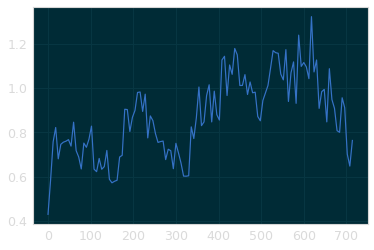

In [12]:
ts.mean(axis=1).plot()

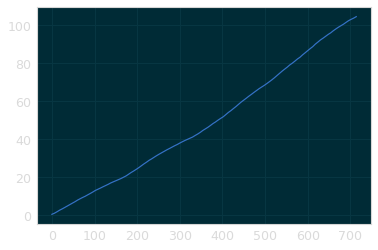

In [13]:
ts.cumsum().mean(axis=1).plot()

In [14]:
sending_times = received.time.unique()
sending_times

array([  0, 168, 336, 408, 504, 576])

In [15]:
sending_times[1:] - sending_times[:-1]

array([168, 168,  72,  96,  72])

In [16]:
168/24

7.0

Let's assume that the period of interest for an offer is always 10 days after it was received. Let's make a table that shows if an offer was received in the past 10 days.

In [17]:
received.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [18]:
user = received[received.person == received.person[0]]
user

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,75.0,2017-05-09,F,100000.0,0,17295,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,75.0,2017-05-09,F,100000.0,0,17295,10.0,7.0,bogo,10.0,0.0,1.0,1.0,1.0
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0


In [19]:
offers = portfolio.id.values

In [20]:
offer_ts = pd.DataFrame(np.zeros((data.time.nunique(), len(offers))),
                        index=data.time.unique(), columns=offers)
offer_ts.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
delta = 24 * 10
for i, row in user.iterrows():
    offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1

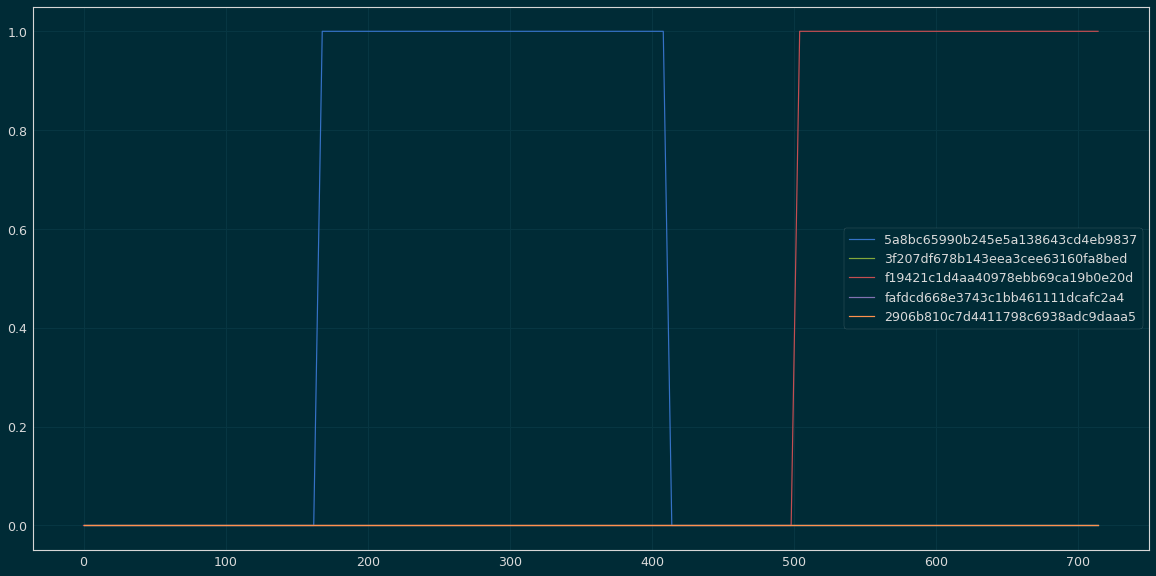

In [27]:
offer_ts.loc[:, user.offer_id].plot()

In [28]:
def get_offers_ts(user_received, portfolio, data, delta = 24 * 10, viewed=False):
    """ 
    Given the received sequence for a user, this function returns a time series
    dataframe containing a 1 in a 10 days period after receiving an offer.
    It can filter out the non-viewed offers.
    Args:
        user_received(dataframe): The received offers for one user.
        portfolio(dataframe): The original portfolio of offers (just to get the offer ids).
        data(dataframe): The original transcript (just to get the time values).
        delta(int): The period of relevance for an offer.
        viewed(boolean): Whether to show only the offers that were viewed.
    """
    offers = portfolio.id.values
    offer_ts = pd.DataFrame(np.zeros((data.time.nunique(), len(offers))),
                            index=data.time.unique(), columns=offers)
    for i, row in user_received.iterrows():
        if viewed:
            if row.viewed:
                offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1
        else:
            offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1
    # Fill the "no-offer" column
    offer_ts['no_offer'] = (offer_ts.sum(axis=1) == 0).astype(int)
    return offer_ts

Let's plot the offers' relevant periods considering all the offers received and only those that were viewed.

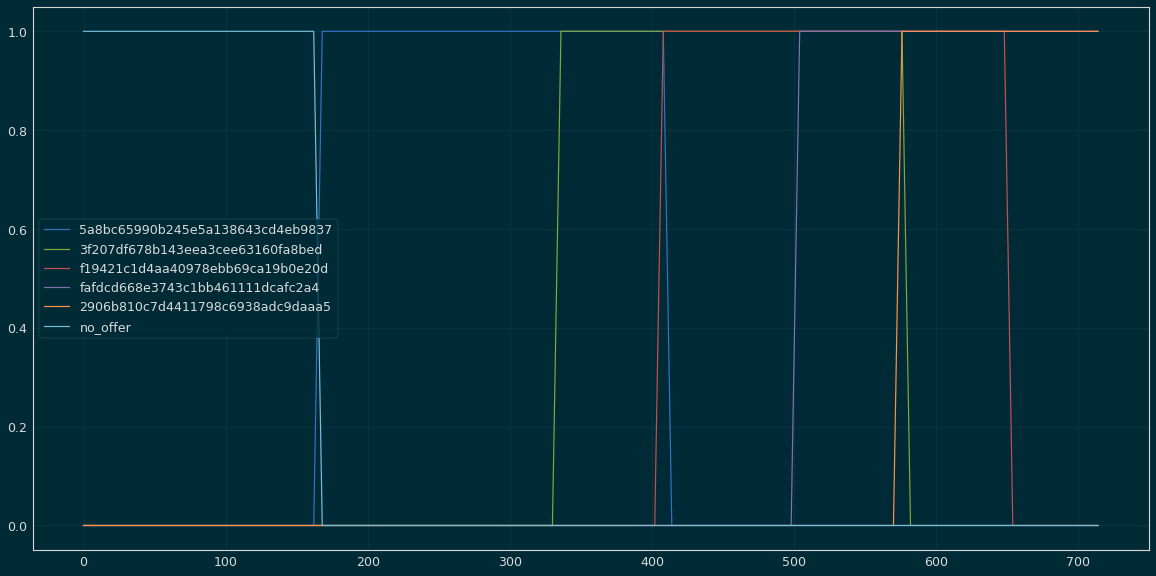

In [29]:
user = static_data[static_data.person == static_data.person[1]]
interesting_offers = user.offer_id.tolist() + ['no_offer']
offer_times = get_offers_ts(user, portfolio, data, viewed=False)
offer_times.loc[:, interesting_offers].plot()

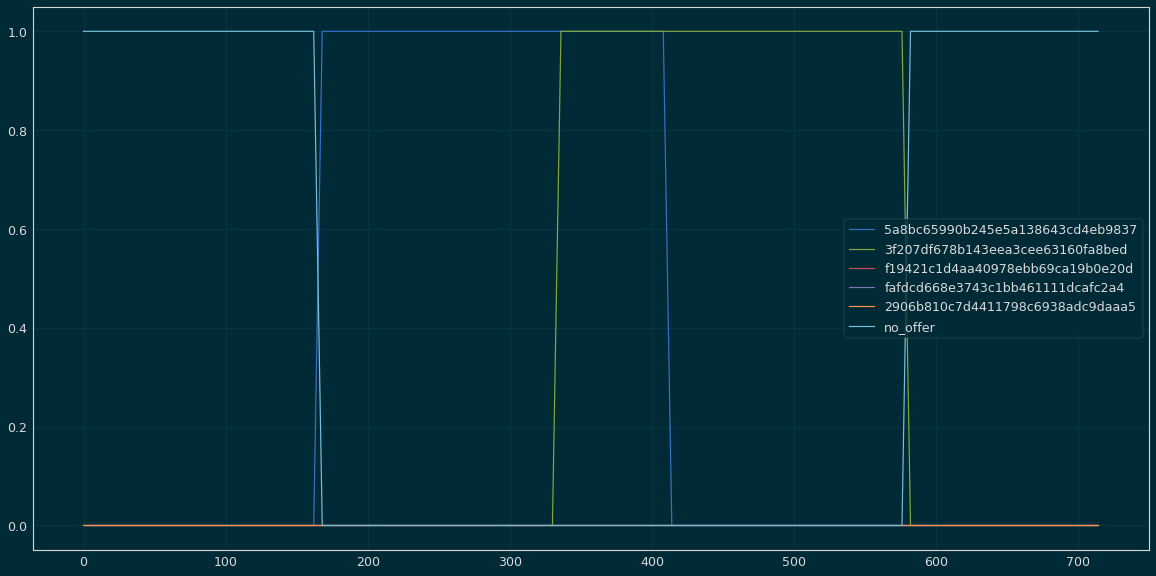

In [30]:
get_offers_ts(user, portfolio, data, viewed=True).loc[:, interesting_offers].plot()

There is overlap. Let's see if the offers, in mean, behave similarly in their full period of interest. If that is true, a model could be implemented on a day-to-day basis, and the overlapping zones could be ignored, or taken into account in an easier way.

In [31]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
offer = portfolio.id[0]
offer

'ae264e3637204a6fb9bb56bc8210ddfd'

In [33]:
# Create empty time series
ts = pd.DataFrame(np.zeros((data.time.nunique(), data.person.nunique())), 
                  index=data.time.unique(), columns=data.person.unique())

ts.update(transactions.pivot_table(index='time',
                              columns='person',
                              values='amount',
                              aggfunc='sum'))

In [34]:
ts.shape

(120, 17000)

In [35]:
static_data.shape

(76277, 132)

In [ ]:
%time multi_offer_times = static_data.groupby('person').apply(lambda x: get_offers_ts(x, portfolio, data, viewed=False).stack() )

In [ ]:
multi_ot.shape

In [ ]:
portfolio.shape

In [ ]:
120 * 11

In [ ]:
multi_ot.head()

In [ ]:
offer_times = get_offers_ts(user, portfolio, data, viewed=False)
offer_times.stack()

## 1) Let's get the spent money in 10 days from the offer reception, without taking into account the overlapping or the views.

In [2]:
# Get the data
static_data = pd.read_pickle(STATIC_DATASET_PATH)
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
received, viewed, completed, transactions = pp.split_transcript(data)

CPU times: user 2.83 s, sys: 180 ms, total: 3.01 s
Wall time: 1.87 s


In [65]:
static_data.shape

(76277, 132)

In [66]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
from tqdm import tqdm

In [72]:
delta = 10 * 24

results = list()
for idx, row in tqdm(static_data.iterrows()):
    record = dict()
    
    # Id of the record
    record['person'] = row.person
    record['time'] = row.time
    record['offer_id'] = row.offer_id
    
    record['spent_10_days'] = transactions[(transactions.person == row.person) &
                                           (transactions.time > row.time) &
                                           (transactions.time <= row.time + delta)
                                          ].amount.sum()
    results.append(record)

76277it [18:29, 68.76it/s]


In [73]:
results

[{'person': '0009655768c64bdeb2e877511632db8f',
  'time': 168,
  'offer_id': '5a8bc65990b245e5a138643cd4eb9837',
  'spent_10_days': 22.16},
 {'person': '0009655768c64bdeb2e877511632db8f',
  'time': 336,
  'offer_id': '3f207df678b143eea3cee63160fa8bed',
  'spent_10_days': 46.510000000000005},
 {'person': '0009655768c64bdeb2e877511632db8f',
  'time': 408,
  'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d',
  'spent_10_days': 46.510000000000005},
 {'person': '0009655768c64bdeb2e877511632db8f',
  'time': 504,
  'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4',
  'spent_10_days': 96.86999999999999},
 {'person': '0009655768c64bdeb2e877511632db8f',
  'time': 576,
  'offer_id': '2906b810c7d4411798c6938adc9daaa5',
  'spent_10_days': 58.92999999999999},
 {'person': '00116118485d4dfda04fdbaba9a87b5c',
  'time': 168,
  'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d',
  'spent_10_days': 0.7000000000000001},
 {'person': '00116118485d4dfda04fdbaba9a87b5c',
  'time': 576,
  'offer_id': 'f19421c1d4aa40978eb

In [74]:
filled = static_data.merge(pd.DataFrame(results), on=['person', 'time', 'offer_id'], how='left')

In [75]:
print(filled.shape)
filled.head()

(76277, 133)


,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.87
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.93


In [76]:
filled.spent_10_days.sum()

2759280.54

In [77]:
filled.to_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [3]:
filled = pd.read_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

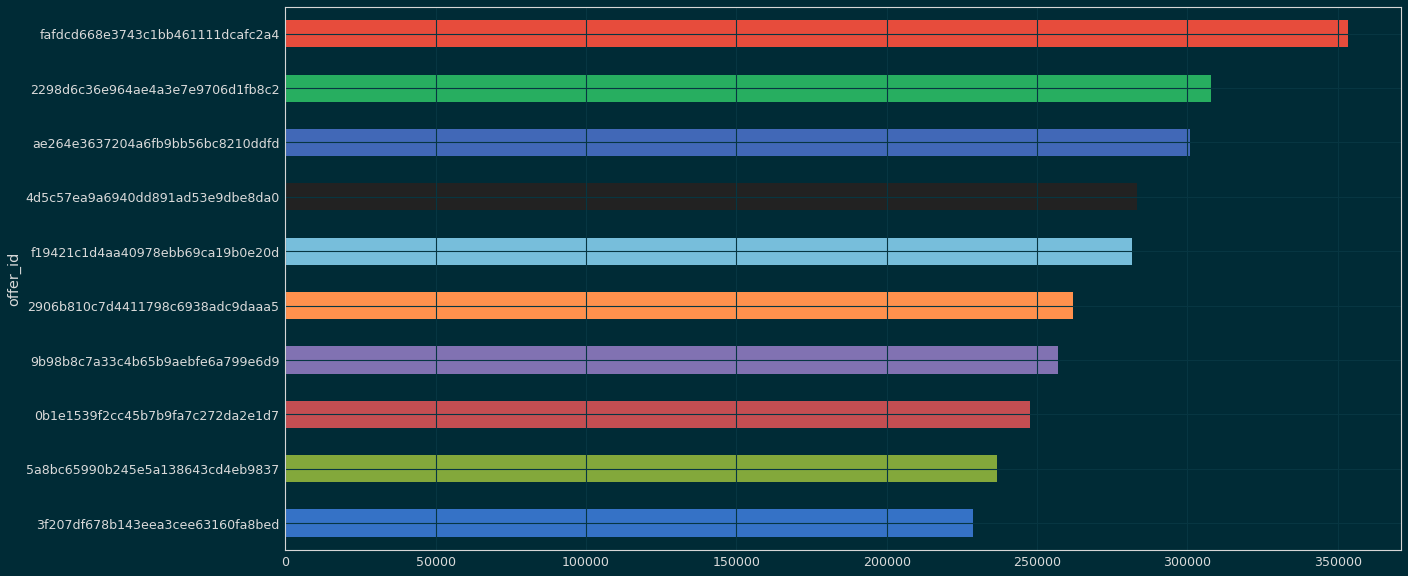

In [10]:
filled.groupby('offer_id').spent_10_days.sum().sort_values().plot(kind='barh')

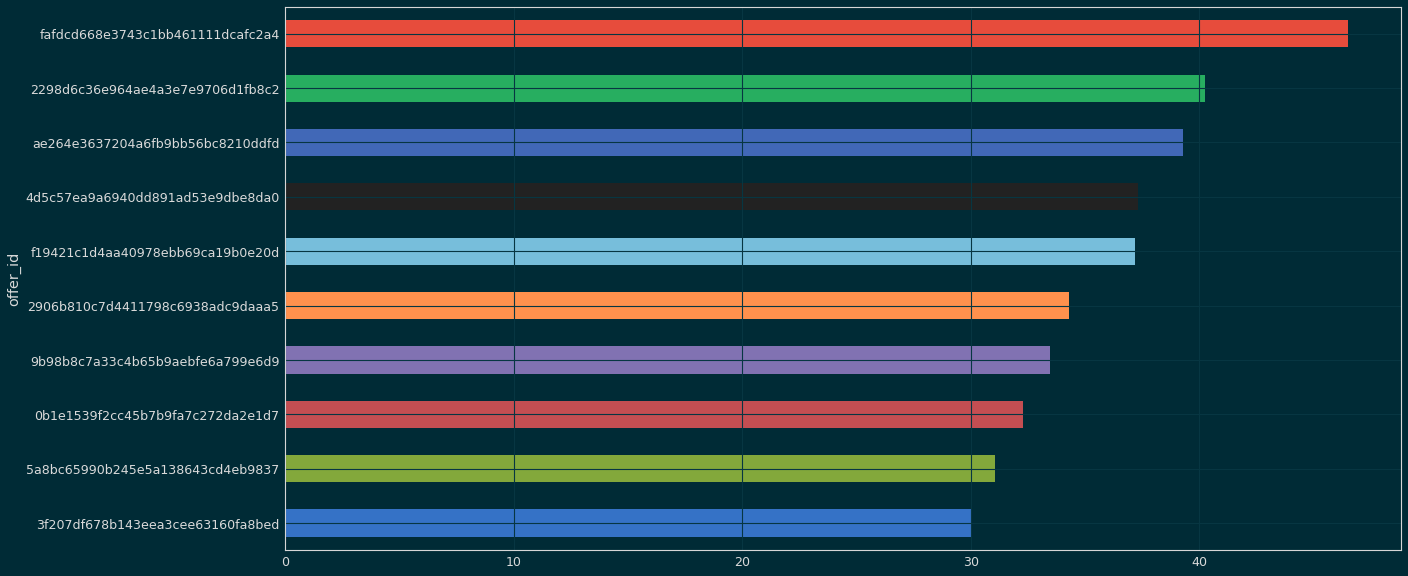

In [11]:
filled.groupby('offer_id').spent_10_days.mean().sort_values().plot(kind='barh')

In [12]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_email,channel_social,channel_mobile,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


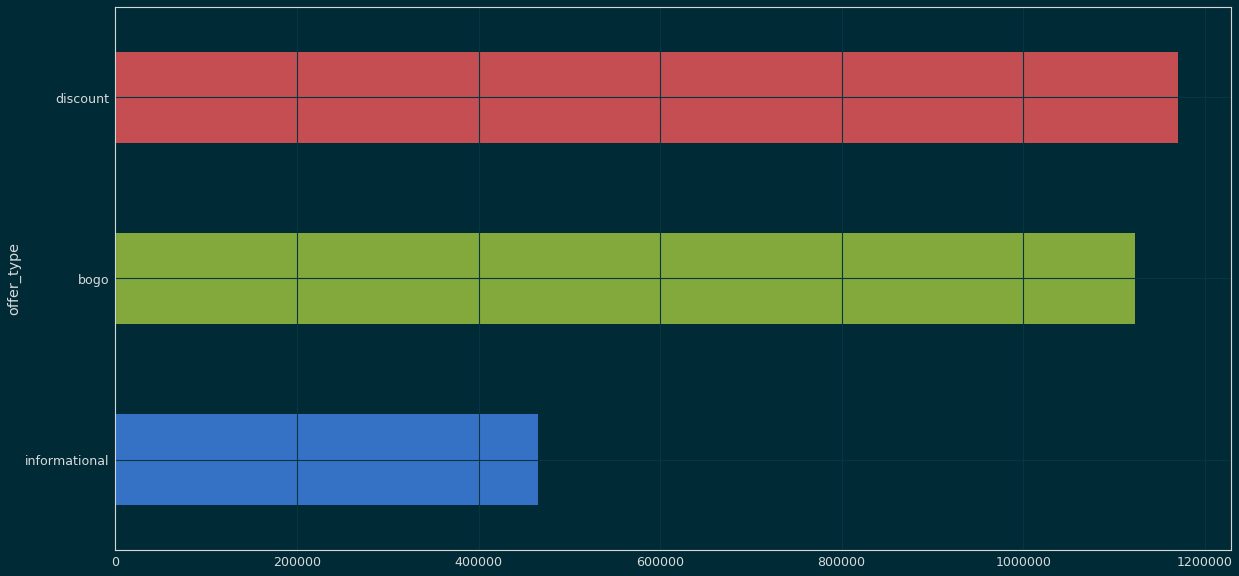

In [13]:
filled.groupby('offer_type').spent_10_days.sum().sort_values().plot(kind='barh')

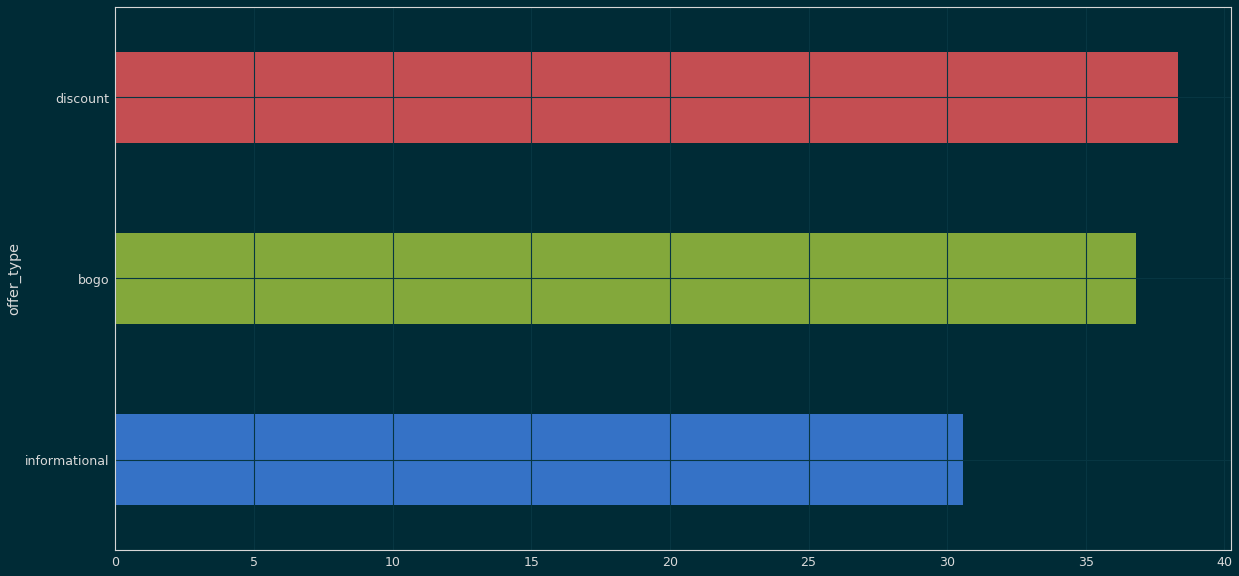

In [14]:
filled.groupby('offer_type').spent_10_days.mean().sort_values().plot(kind='barh')

## 2) Let's consider the non-viewed for the "null" offer.

In [3]:
# Get the data
static_data = pd.read_pickle(STATIC_DATASET_PATH)
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
received, viewed, completed, transactions = pp.split_transcript(data)

CPU times: user 2.61 s, sys: 114 ms, total: 2.72 s
Wall time: 1.64 s


In [2]:
filled = pd.read_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [14]:
# TODO: Add these records at the end of the dataframe
filled['offer_choice'] = filled['offer_id']
filled.loc[filled['viewed'] == 0, 'offer_choice'] = 'no_offer'

In [15]:
filled.offer_choice.value_counts()

no_offer                            19050
fafdcd668e3743c1bb461111dcafc2a4     6932
4d5c57ea9a6940dd891ad53e9dbe8da0     6861
2298d6c36e964ae4a3e7e9706d1fb8c2     6853
f19421c1d4aa40978ebb69ca19b0e20d     6698
ae264e3637204a6fb9bb56bc8210ddfd     6318
5a8bc65990b245e5a138643cd4eb9837     6208
0b1e1539f2cc45b7b9fa7c272da2e1d7     4500
2906b810c7d4411798c6938adc9daaa5     4363
3f207df678b143eea3cee63160fa8bed     4263
9b98b8c7a33c4b65b9aebfe6a799e6d9     4231
Name: offer_choice, dtype: int64

In [17]:
filled.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3f207df678b143eea3cee63160fa8bed
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,no_offer
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.87,no_offer
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.93,no_offer


In [26]:
print(filled.shape)
print(filled.columns)

(76277, 134)
Index(['person', 'time', 'offer_id', 'age', 'became_member_on', 'gender',
       'income', 'missing_demographics', 'member_epoch_days', 'difficulty',
       ...
       'reward_0.0_success_ratio', 'reward_5.0_success_ratio',
       'reward_3.0_success_ratio', 'reward_2.0_success_ratio',
       'channel_web_success_ratio', 'channel_email_success_ratio',
       'channel_social_success_ratio', 'channel_mobile_success_ratio',
       'spent_10_days', 'offer_choice'],
      dtype='object', length=134)


In [39]:
data = filled
time_limit = 450
drop_time = True
anon_person = True
anon_offer = True
data = data.drop('became_member_on', axis=1)
if anon_person:
        data = data.drop('person', axis=1)
if anon_offer:
        data = data.drop('offer_id', axis=1)
X = data.drop(pp.FUTURE_INFO, axis=1)
y = data['success']
X_train, X_test, y_train, y_test = sd.time_split(X, y, time_limit,
                                              drop_time=drop_time)

In [40]:
X_train.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5a8bc65990b245e5a138643cd4eb9837
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3f207df678b143eea3cee63160fa8bed
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,no_offer
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,f19421c1d4aa40978ebb69ca19b0e20d
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.49,3f207df678b143eea3cee63160fa8bed


In [41]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_social,channel_mobile,channel_web,channel_email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


In [6]:
# TODO: Fill all the other "offer" fields if it was not viewed, with standard values.

In [ ]:
def get_profit_10_days_data(basic_dataset_path=os.path.join(DATA_INTERIM, 'static_data.pkl'),
                            time_limit=450,
                            drop_time=True,
                            anon_person=True,
                            anon_offer=True):
    data = pd.read_pickle(basic_dataset_path)
    
    

In [44]:
from sklearn.preprocessing import LabelEncoder

In [60]:
class BasicEncoderProfits(pp.BasicEncoder):
    """ Transforms the Basic dataset. Adds the encoding for the offer choice. """

    def __init__(self):
        super().__init__()
        self.offer_choice_encoder = LabelEncoder()

    def fit(self, X, y=None):
        """ Get the encodings for the offer choice. """
        super().fit(X, y)
        self.offer_choice_encoder.fit(X['offer_choice'])
        return self

    def transform(self, X):
        """ Encode offer types and gender """
        res = super().transform(X)
        res['offer_choice'] = self.offer_choice_encoder.transform(X['offer_choice'])
        return res

    def inverse_transform(self, X):
        """ Transform back to the original encoding. """
        res = super().inverse_transform(X)
        res['offer_choice'] = self.offer_choice_encoder.inverse_transform(X['offer_choice'])
        return res

In [61]:
encoder = BasicEncoderProfits()

In [62]:
encoder.fit(X_train)

BasicEncoderProfits()

In [63]:
X_train_t = encoder.transform(X_train)
X_train_t.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice
0,33.0,1.0,72000.0,0,17277,0.0,3.0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5
1,33.0,1.0,72000.0,0,17277,0.0,4.0,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3
2,33.0,1.0,72000.0,0,17277,5.0,5.0,0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,10
5,NaN,NaN,NaN,1,17646,5.0,5.0,0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,8
7,40.0,2.0,57000.0,0,17540,0.0,4.0,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.49,3


In [66]:
sorted(X_train_t.offer_choice.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [69]:
X_train_o = encoder.inverse_transform(X_train_t)

In [70]:
X_train_o.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio,spent_10_days,offer_choice
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.16,5a8bc65990b245e5a138643cd4eb9837
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,3f207df678b143eea3cee63160fa8bed
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.51,no_offer
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,f19421c1d4aa40978ebb69ca19b0e20d
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.49,3f207df678b143eea3cee63160fa8bed


## 3) Let's deal with the overlapping.

In [ ]:
def get_offer_transactions(offer_id):
    